# Spiraling complexity: a test of the snowball effect in a computational model of RNA folding

Our RNA folding model uses the Vienna RNA package (http://www.tbi.univie.ac.at/RNA/#download). You install the package with Python binding so you'll be able to import the Vienna RNA package as a library when running our RNA folding model.

In [1]:
run /Users/HansSachs/Google\ Drive/Scripts/RNA_folding_model.py

A simulation strats by selecting a random seqeunce as the reference sequence. The fitness of RNA sequence $i$ is determined using the step function:

$w_{i} = \left\{\begin{array}{ll}
        1 & \quad  \mathrm{if}  \quad \beta_i>\alpha \quad \mathrm{and} \quad  \delta_i \leqslant \alpha\\
        0 & \quad  \mathrm{otherwise}   \\
        \end{array}\right.$
        
where $\beta_i$ is the number of base pairs in the secondary structure of sequence $i$,
$\delta_{i}$ is the base-pair distance between the structure of sequence $i$ and the reference structure, and $\alpha$ is an arbitrary threshold.

We start each simulation by picking a reference sequences.

In [2]:
ref_seq = 'UAGACUAUAAAGUACCGGGAUCUAUUGAAUGUUGGUACCCCUUUCGAGUGAUUGCGCCCCAGUCCGUGAACUAGGAUGCAUAUUUACCUAUUCAGAGGAU'

We define an ``Evolution'' object and set $\alpha$. By default $\alpha = 12$.

In [3]:
evo = Evolution(ref_seq, alpha=12)

We can set number of substitutions during evolution (``divergence'') and the length of the burn-in period (``burnin'').

In [4]:
evo.evolve(divergence=40, burnin=200, verbose=True)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40


``stats'' is a dictionary that stores all the calculations and can be directly saved to file at the end of each run.

In [5]:
results = evo.stats

As shown in the plot below, after each substitution, the Hamming distance between the diverging RNA sequences increases by one:

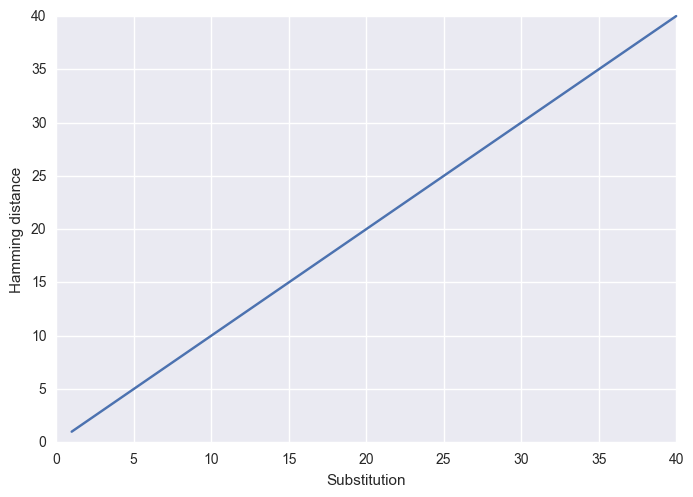

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(np.arange(1, 41, 1), results['divergence'], clip_on=False)
plt.ylabel('Hamming distance')
plt.xlabel('Substitution')

Simple DMIs accumulate following substitutions:

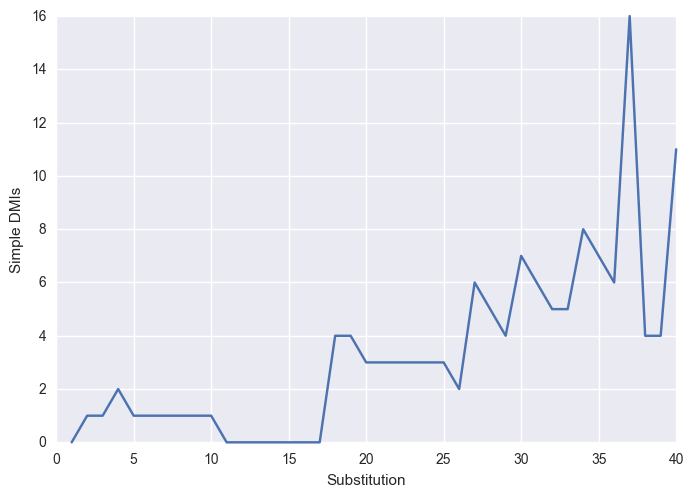

In [7]:
plt.plot(np.arange(1, 41, 1), results['SDMI_count'], clip_on=False)
plt.ylabel('Simple DMIs')
plt.xlabel('Substitution')

# Model fitting

In [8]:
%load_ext rpy2.ipython

We fit a linear model:
$$I = b(k - 1)$$ 
and the Orr model:
$$I = \frac{k(k-1)p}{2} \quad ,$$
where $k$ is the Hamming distance between the diverging seqeunces and $I$ is the number of incompatibilties.

In [9]:
x =  np.arange(1, 41, 1)
y = results['SDMI_count']

In [10]:
%%R -i x -i y -o b
lin = nls(y ~ b * (x - 1), start=list(b=.1))
b = summary(lin)$coef[1, 1] 
summary(lin)


Formula: y ~ b * (x - 1)

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
b   0.1822     0.0154   11.84 1.76e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.207 on 39 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 4.126e-09



In [11]:
%%R -i x -i y -o p
orr = nls(y ~ p * x * (x - 1)/2, start=list(p=0.1))
p = summary(orr)$coef[1, 1]
summary(orr)


Formula: y ~ p * x * (x - 1)/2

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
p 0.0118320  0.0008842   13.38  3.7e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2 on 39 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 7.475e-08



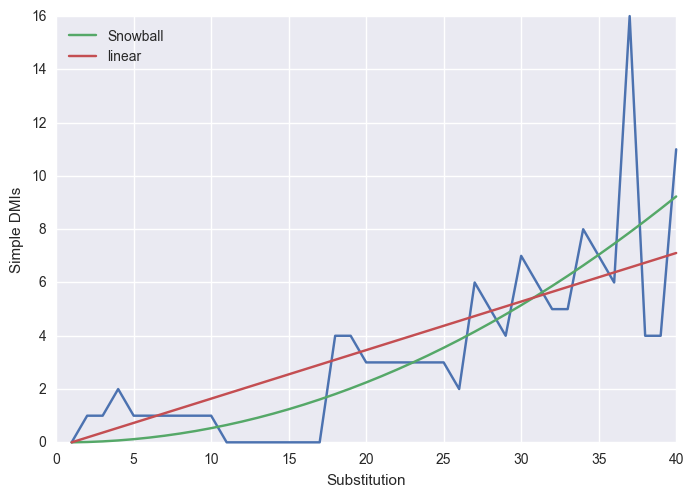

In [12]:
plt.plot(x, y, clip_on=False)
plt.plot(x, [p[0] * i * (i - 1)/2. for i in x], clip_on=False, label='Snowball')
plt.plot(x, [b[0]* (i - 1) for i in x], clip_on=False, label='linear')
plt.ylabel('Simple DMIs')
plt.xlabel('Substitution')
plt.legend(loc='upper left')

Model selecting is done by comparing the AIC scores of each model. Lower AIC means better fit. 

In [13]:
%%R
cat(AIC(orr), AIC(lin))

171.9439 179.8227